In [1]:
from scipy.io import loadmat
from pandas import factorize
import pickle
import numpy as np
import random
from scipy import signal

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions to load datasets

In [3]:
# RadioML2016.10a

def load_dataset(dataset_location):
    """
    Load dataset and extract needed data

    Input: 
        dataset_location: specify where the file is stored and its name

    Output:
        snrs: list of the SNR range in dataset [-20 to 18]
        X: array of the measured I/Q data [num_of_samples, 128, 2]
        modulations: list of the modulations in this dataset
        one_hot_encode: one_hot encoded data - the other maps the order of the mods
        lbl_SNR: list of each snr (for plotting)
    """

    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset_location.keys())))), [1,0])

    X = []; I = []; Q = []; lbl = [];

    for mod in mods:
        for snr in snrs:
            X.append(dataset_location[(mod,snr)])
            for i in range(dataset_location[(mod,snr)].shape[0]):  
                lbl.append((mod,snr))
    X = np.vstack(X); lbl=np.vstack(lbl)

    X = np.transpose(X[:,:,:],(0,2,1))

    # One-hot-encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)    
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)



    return snrs, X, mods, one_hot_encode, lbl_SNR

## Functions to handle the datasets

In [4]:
def train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15):
    
    """
    Train-Test split the data

    Input:
        X: X data
        one_hot: Y data encoded to one_hot
        train_split (default 0.7)
        valid_split (default 0.15)
        test_split (default 0.15)
        train_split : valid_split : test_split - ratio for splitting the dataset
        
        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data 
        test_idx: indexes from X assinged to test data
        X_train: X data assigned for training
        X_valid: X data assigned for validation
        X_test: X data assigned for testing
        Y_train: one-hot encoded Y data assigned for training
        Y_valid: one-hot encoded Y data assigned for validation
        Y_test: one-hot encoded Y data assigned for testing
    """

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)
    
    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))
    
    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)
    
    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)
    
    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]   
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]  

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test



In [5]:
def normalize_data(X_train, X_valid, X_test):
        # mean-std normalization

    mean = X_train[:,:,:].mean(axis=0)
    X_train[:,:,:] -= mean
    std = X_train[:,:,:].std(axis=0)
    X_train[:,:,:] /= std


    X_valid[:,:,:] -= mean
    X_valid[:,:,:] /= std

    X_test[:,:,:] -= mean
    X_test[:,:,:] /= std

    return X_train, X_valid, X_test

In [6]:
def return_indices_of_a(a, b):
    """
    Compare two lists a, b for same items and return indeces
    of the item in list a

    a:    List of items, its indeces will be returned
    b:    List of items to search for in list a
    """
    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]

## Functions for plotting

In [7]:
def show_confusion_matrix(validations, predictions, matrix_snr, save=False):
    """
    Plot confusion matrix

    validations:    True Y labels
    predictions:    Predicted Y labels of your model
    matrix_snr:     SNR information for plot's title
    """
  
    cm = confusion_matrix(validations, predictions)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', xticklabels=mods, yticklabels=mods)
    sns.set(font_scale=1.3)
    if matrix_snr == None:
        plt.title("Confusion Matrix")
    else:
        plt.title("Confusion Matrix \n" + str(matrix_snr) + "dB")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    if save == True:
        plt.savefig(base_dir + 'Own_dataset/' + str(matrix_snr) + '.png')    
    plt.show(block=False)
    

In [8]:
def All_SNR_show_confusion_matrix(X_test, save=False):
    """
    Plot confusion matrix of all SNRs in one

    X_test:   X_test data
    """
    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))

    show_confusion_matrix(Y_Pred, Y_Test, None, save)

In [9]:
def SNR_show_confusion_matrix(in_snr, lbl_SNR, X_test, save=False):
    """
    Plot confusion matrices of chosen SNRs

    in_snr:   must be list of SNRs
    X_test:   X_test data
    """
    for snr in in_snr:
        matrix_snr = snr
        print(snr)
        m_snr = matrix_snr;

        Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = []; 
        matrix_snr_index = [];

        prediction = model.predict(X_test)

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        for i in range(len(lbl_SNR)):
            if int(lbl_SNR[i]) == m_snr:
                matrix_snr_index.append(i)

        indeces_of_Y_test = return_indices_of_a(test_idx, matrix_snr_index)

        for i in indeces_of_Y_test:
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])
        show_confusion_matrix(Y_Pred_SNR, Y_Test_SNR, matrix_snr, save)

In [10]:
def plot_split_distribution(mods, Y_train, Y_valid, Y_test):

    x = np.arange(len(mods))  # the label locations
    width = 1  # the width of the bars

    fig, ax = plt.subplots()
    bar1 = ax.bar(x-width*0.3, np.count_nonzero(Y_train == 1, axis=0), width*0.3, label = "Train" )
    bar2 = ax.bar(x , np.count_nonzero(Y_valid == 1, axis=0), width*0.3, label = "Valid" )
    bar3 = ax.bar(x+width*0.3, np.count_nonzero(Y_test == 1, axis=0), width*0.3, label = "Test" )


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Distribution')
    ax.set_title('Distribution overview of splitted dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(mods)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=5)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            
    #autolabel(bar1)
    #autolabel(bar2)
    #autolabel(bar3)
    #fig.tight_layout()
    return plt.show()

In [11]:
def SNR_accuracy(in_snr, name):
    """
    Computes accuracies of chosen SNRs individualy
  
    in_snr:   must be list of SNRs
    """
    
    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(SNR, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    ax.legend(loc=4, prop={'size': 25})

    x_major_ticks = np.arange(-20, 19, 2 )
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10 )
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-20, 18)
    plt.ylim(0,100)
    plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy (%)',fontsize=20)
    plt.xlabel('SNR (dB)',fontsize=20)
    # plt.savefig(base_dir + name + '.png') 
    plt.show()

    return acc[:,1]


## Functions for visualization of layers

In [12]:
def layer_overview(model):

    """
    Offers overview of the model's layers and theirs outputs

    model: specify trained model you want to have overview of
    """

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    return layer_names, layer_outputs

def model_visualization(nth_layer, nth_test_idx, mods, model,
                        plot_sample = False, plot_activations = True, 
                        plot_feature_maps = True):
    
    """
    The function provised overview of activation of specific layer and its
    feature maps.

    nth_layer: enter number which corresponds with the position of wanted layer 
    nth_test_idx: enter number pointing at the test indexes from earlier
    mods: provide variable which holds listed modulations
    model: specify which trained model to load
    plot_sample = False: set to true to plot sample data
    plot_activations = True: plots activation of chosen layer
    plot_feature_maps = True: plots feature map of chosen layer
    """

    # Sample data for visualization
    test_sample = X_test[nth_test_idx,:,:] # shape [128,2]
    test_sample = test_sample[None] # change to needed [1,128,2]
    SNR = lbl_SNR[test_idx[nth_test_idx]]
    mod = one_hot[test_idx[nth_test_idx]]
    f, u = factorize(mods)
    print(u)
    indices=np.where(mod==1.)
    mod = mod[indices[0]]

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    ## Activations ##

    # define activation model
    activation_model = tf.keras.models.Model(model.input, layer_outputs)

    # get the activations of chosen test sample
    activations = activation_model.predict(test_sample)

    ## Feature-maps ##

    # define feature maps model 
    feature_maps_model = tf.keras.models.Model(model.inputs, model.layers[4].output)
    
    # get the activated features
    feature_maps = feature_maps_model.predict(test_sample)


    # Plot sample
    if plot_sample == True:
        plt.plot(test_sample[0,:,:])
        plt.title(mod + '    ' + str(SNR) + 'dB')
        plt.show()

    # Plot activations
    if plot_activations == True:
        activation_layer = activations[nth_layer]
        activation_layer = np.transpose(activation_layer[:,:,:],(0,2,1)) # reshape
        fig, ax = plt.subplots(figsize=(20,10))
        ax.matshow(activation_layer[0,:,:],  cmap='viridis')
        # plt.matshow(activation_layer[0,:,:],  cmap='viridis')
        plt.title('Activation of layer ' + layer_names[nth_layer])
        ax.grid(False)
        ax.set_xlabel('Lenght of sequence')
        ax.set_ylabel('Filters')
        fig.show()
        plt.savefig(base_dir + 'activations.png')
        plt.savefig(base_dir + 'activations.svg')

    # Plot feature maps
    if plot_feature_maps == True:
        n_filters = int(feature_maps.shape[2]/2); ix = 1
        fig = plt.figure(figsize=(25,15))
        for _ in range(n_filters):
            for _ in range(2):
                # specify subplot and turn of axis
                ax =fig.add_subplot(n_filters,  5, ix)
                # ax = plt.subplot(n_filters,  5, ix, )
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                ax.plot(feature_maps[0, :, ix-1])
                ix += 1
        # show the figure
        fig.show()
        plt.savefig(base_dir + 'feature_map.png')
        plt.savefig(base_dir + 'feature_map.svg')

In [13]:
dataset_pkl = open('/content/drive/MyDrive/btp/RML2016.10a_dict.pkl','rb')
RML_dataset_location = pickle.load(dataset_pkl, encoding='bytes')

## DeepSig Dataset

In [14]:
# 10a
SNR, X, modulations, one_hot, lbl_SNR = load_dataset(RML_dataset_location)

In [15]:
mods = []
for i in range(len(modulations)):
    modu = modulations[i].decode('utf-8')
    mods.append(modu)

In [16]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)

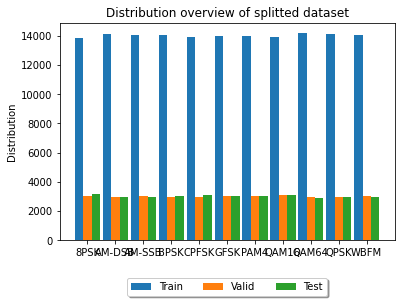

In [17]:
plot_split_distribution(mods, Y_train, Y_valid, Y_test)

In [18]:
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

## CNN

In [19]:

cnn_in = keras.layers.Input(shape=(128,2))
cnn = keras.layers.ZeroPadding1D(padding=4)(cnn_in)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=4, activation='relu')(cnn)
cnn = keras.layers.Dropout(rate=0.6)(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Flatten()(cnn)
cnn = keras.layers.Dense(70, activation='selu')(cnn)
cnn_out = keras.layers.Dense(len(mods), activation='softmax')(cnn)

model_cnn = keras.models.Model(cnn_in, cnn_out)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, min_lr=0.00007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)]

optimizer = keras.optimizers.Adam(learning_rate=0.0007)

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 zero_padding1d (ZeroPadding  (None, 136, 2)           0         
 1D)                                                             
                                                                 
 conv1d (Conv1D)             (None, 129, 50)           850       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 50)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 57, 50)            20050     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 28, 50)           0     

In [21]:
tf.keras.backend.clear_session()
history = model_cnn.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=2, validation_data= (X_valid, Y_valid), callbacks=callbacks)


Epoch 1/50
1204/1204 - 20s - loss: 1.5312 - accuracy: 0.4123 - val_loss: 1.3084 - val_accuracy: 0.5016 - lr: 7.0000e-04 - 20s/epoch - 17ms/step
Epoch 2/50
1204/1204 - 10s - loss: 1.2870 - accuracy: 0.5022 - val_loss: 1.2626 - val_accuracy: 0.5197 - lr: 7.0000e-04 - 10s/epoch - 8ms/step
Epoch 3/50
1204/1204 - 9s - loss: 1.2482 - accuracy: 0.5197 - val_loss: 1.2502 - val_accuracy: 0.5247 - lr: 7.0000e-04 - 9s/epoch - 8ms/step
Epoch 4/50
1204/1204 - 9s - loss: 1.2281 - accuracy: 0.5279 - val_loss: 1.2419 - val_accuracy: 0.5281 - lr: 7.0000e-04 - 9s/epoch - 8ms/step
Epoch 5/50
1204/1204 - 9s - loss: 1.2123 - accuracy: 0.5340 - val_loss: 1.2198 - val_accuracy: 0.5368 - lr: 7.0000e-04 - 9s/epoch - 8ms/step
Epoch 6/50
1204/1204 - 9s - loss: 1.2020 - accuracy: 0.5384 - val_loss: 1.2060 - val_accuracy: 0.5408 - lr: 7.0000e-04 - 9s/epoch - 8ms/step
Epoch 7/50
1204/1204 - 9s - loss: 1.1929 - accuracy: 0.5424 - val_loss: 1.2034 - val_accuracy: 0.5391 - lr: 7.0000e-04 - 9s/epoch - 8ms/step
Epoch 8/

In [22]:
model = keras.models.load_model("cnn_model.h5")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1032/1032 [==============================] - 7s 7ms/step - loss: 1.1396 - accuracy: 0.5696
Test accuracy 0.569636344909668
Test loss 1.139566421508789



SNR -20dB:
50/50 - 0s - loss: 2.5500 - accuracy: 0.0939 - 476ms/epoch - 10ms/step

SNR -18dB:
52/52 - 0s - loss: 2.5580 - accuracy: 0.0752 - 287ms/epoch - 6ms/step

SNR -16dB:
53/53 - 0s - loss: 2.4883 - accuracy: 0.0995 - 293ms/epoch - 6ms/step

SNR -14dB:
54/54 - 0s - loss: 2.3724 - accuracy: 0.1171 - 315ms/epoch - 6ms/step

SNR -12dB:
50/50 - 0s - loss: 2.2146 - accuracy: 0.1575 - 213ms/epoch - 4ms/step

SNR -10dB:
53/53 - 0s - loss: 2.0164 - accuracy: 0.2202 - 221ms/epoch - 4ms/step

SNR -8dB:
52/52 - 0s - loss: 1.6944 - accuracy: 0.3362 - 280ms/epoch - 5ms/step

SNR -6dB:
52/52 - 0s - loss: 1.3468 - accuracy: 0.4739 - 302ms/epoch - 6ms/step

SNR -4dB:
53/53 - 0s - loss: 0.9838 - accuracy: 0.6038 - 236ms/epoch - 4ms/step

SNR -2dB:
52/52 - 0s - loss: 0.6907 - accuracy: 0.7242 - 290ms/epoch - 6ms/step

SNR 0dB:
52/52 - 0s - loss: 0.4863 - accuracy: 0.7861 - 289ms/epoch - 6ms/step

SNR 2dB:
51/51 - 0s - loss: 0.4271 - accuracy: 0.8424 - 211ms/epoch - 4ms/step

SNR 4dB:
52/52 - 0s - 

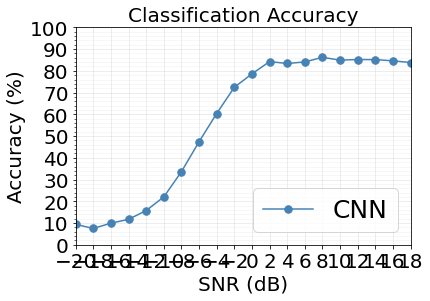

array([0.09388784, 0.07519709, 0.09952607, 0.11710145, 0.1575    ,
       0.22023809, 0.3361806 , 0.47393939, 0.60380727, 0.72420037,
       0.78610605, 0.84239805, 0.83384055, 0.84090906, 0.86232793,
       0.84924924, 0.85200977, 0.85171789, 0.84605986, 0.8382954 ])

In [24]:
SNR_accuracy(SNR, 'CNN')

## CLDNN

In [27]:
layer_in = keras.layers.Input(shape=(128,2))
layer = keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu')(layer_in)
layer = keras.layers.MaxPool1D(pool_size=2)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.LSTM(64, return_sequences=True,)(layer)
layer = keras.layers.Dropout(0.4)(layer)
layer = keras.layers.Flatten()(layer)
layer_out = keras.layers.Dense(len(mods), activation='softmax')(layer)

model_cldnn = keras.models.Model(layer_in, layer_out)

optimizer = keras.optimizers.Adam(learning_rate=0.0007)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cldnn_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, patience=5, min_lr=0.000007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, verbose=1)]

model_cldnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [26]:
model_cldnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 121, 64)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 60, 64)            33024     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                             

In [28]:
tf.keras.backend.clear_session()
history = model_cldnn.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=2, validation_data= (X_valid, Y_valid), callbacks=callbacks)
# history = model_iq.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=2, validation_split=0.15, callbacks=callbacks)


Epoch 1/50
1204/1204 - 44s - loss: 1.5781 - accuracy: 0.3831 - val_loss: 1.4181 - val_accuracy: 0.4433 - lr: 7.0000e-04 - 44s/epoch - 36ms/step
Epoch 2/50
1204/1204 - 40s - loss: 1.3206 - accuracy: 0.4850 - val_loss: 1.2777 - val_accuracy: 0.4941 - lr: 7.0000e-04 - 40s/epoch - 33ms/step
Epoch 3/50
1204/1204 - 34s - loss: 1.2506 - accuracy: 0.5095 - val_loss: 1.2347 - val_accuracy: 0.5158 - lr: 7.0000e-04 - 34s/epoch - 29ms/step
Epoch 4/50
1204/1204 - 36s - loss: 1.2287 - accuracy: 0.5192 - val_loss: 1.2156 - val_accuracy: 0.5281 - lr: 7.0000e-04 - 36s/epoch - 30ms/step
Epoch 5/50
1204/1204 - 33s - loss: 1.2112 - accuracy: 0.5281 - val_loss: 1.1995 - val_accuracy: 0.5346 - lr: 7.0000e-04 - 33s/epoch - 27ms/step
Epoch 6/50
1204/1204 - 36s - loss: 1.1918 - accuracy: 0.5374 - val_loss: 1.1805 - val_accuracy: 0.5450 - lr: 7.0000e-04 - 36s/epoch - 30ms/step
Epoch 7/50
1204/1204 - 37s - loss: 1.1715 - accuracy: 0.5468 - val_loss: 1.1690 - val_accuracy: 0.5508 - lr: 7.0000e-04 - 37s/epoch - 30

In [29]:
model = keras.models.load_model("cldnn_model.h5")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1032/1032 [==============================] - 14s 12ms/step - loss: 1.0729 - accuracy: 0.6108
Test accuracy 0.61075758934021
Test loss 1.0728572607040405



SNR -20dB:
50/50 - 2s - loss: 2.5646 - accuracy: 0.0945 - 2s/epoch - 40ms/step

SNR -18dB:
52/52 - 1s - loss: 2.5743 - accuracy: 0.0807 - 681ms/epoch - 13ms/step

SNR -16dB:
53/53 - 1s - loss: 2.4734 - accuracy: 0.1013 - 667ms/epoch - 13ms/step

SNR -14dB:
54/54 - 1s - loss: 2.3675 - accuracy: 0.1200 - 662ms/epoch - 12ms/step

SNR -12dB:
50/50 - 1s - loss: 2.1934 - accuracy: 0.1663 - 625ms/epoch - 13ms/step

SNR -10dB:
53/53 - 1s - loss: 1.9476 - accuracy: 0.2452 - 672ms/epoch - 13ms/step

SNR -8dB:
52/52 - 1s - loss: 1.5814 - accuracy: 0.3856 - 700ms/epoch - 13ms/step

SNR -6dB:
52/52 - 1s - loss: 1.1623 - accuracy: 0.5339 - 685ms/epoch - 13ms/step

SNR -4dB:
53/53 - 1s - loss: 0.8332 - accuracy: 0.6859 - 685ms/epoch - 13ms/step

SNR -2dB:
52/52 - 1s - loss: 0.5776 - accuracy: 0.7876 - 655ms/epoch - 13ms/step

SNR 0dB:
52/52 - 1s - loss: 0.3862 - accuracy: 0.8617 - 643ms/epoch - 12ms/step

SNR 2dB:
51/51 - 1s - loss: 0.3508 - accuracy: 0.8974 - 629ms/epoch - 12ms/step

SNR 4dB:
52/52

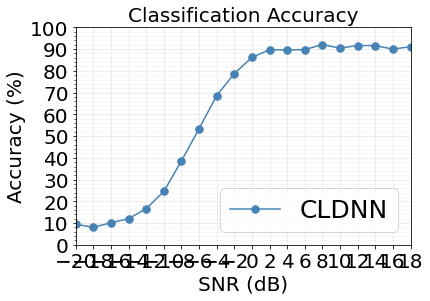

array([0.09451796, 0.08065494, 0.10130332, 0.12      , 0.16625001,
       0.2452381 , 0.38560098, 0.53393942, 0.68590122, 0.78756791,
       0.86166972, 0.89740419, 0.89592206, 0.89803439, 0.92052567,
       0.90450448, 0.91656518, 0.91621459, 0.89981675, 0.9112668 ])

In [29]:
SNR_accuracy(SNR, 'CLDNN')

# Load model


In [30]:
# RadioML2016.10a
model = tf.keras.models.load_model("/content/cldnn_model.h5")

In [24]:
prediction = model.predict([X_test[:,:,:]])

Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = []; 
for i in range(len(prediction[:,0])):
    Y_Pred.append(np.argmax(prediction[i,:]))
    Y_Test.append(np.argmax(Y_test[i]))

Y_Pred[:20], Y_Test[:20]

([1, 1, 8, 4, 9, 2, 1, 2, 0, 8, 2, 3, 9, 1, 1, 4, 0, 10, 0, 0],
 [1, 1, 7, 4, 0, 2, 10, 7, 0, 8, 2, 3, 9, 1, 1, 4, 0, 10, 0, 0])


# Visualize activation and feature map 

In [ ]:
base_dir='/content/'
model_visualization(1,9000, mods, model)

# Plot Confusion Matrix

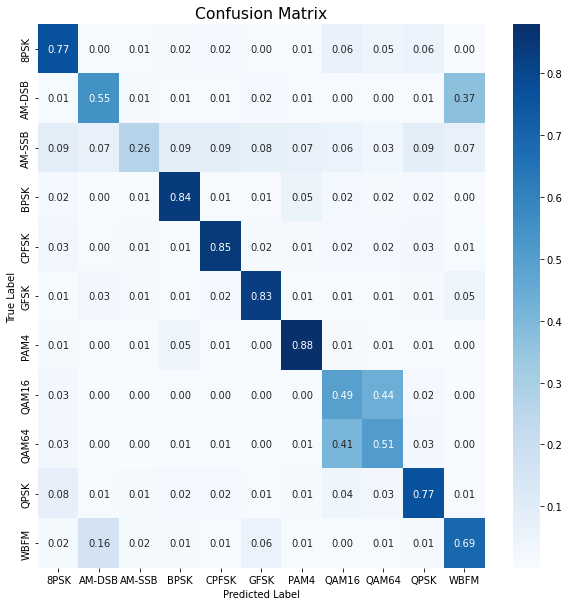

In [25]:
All_SNR_show_confusion_matrix([X_test], save=False)

['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
(220000,)
-6


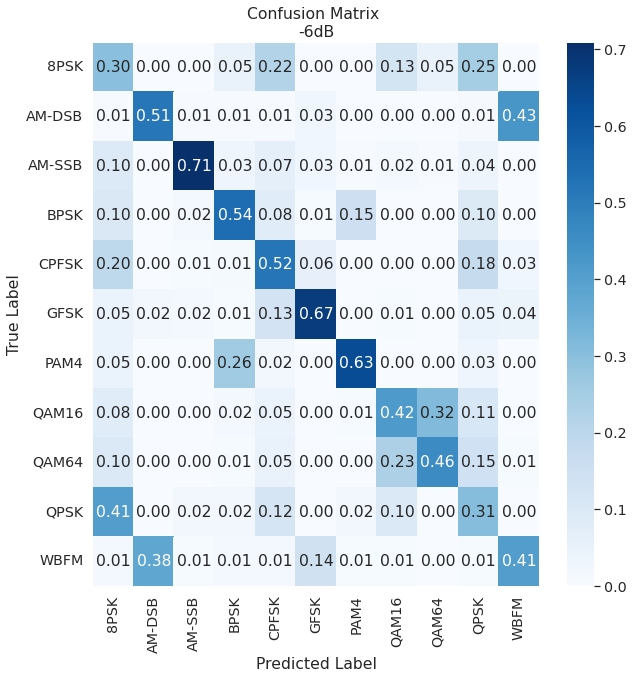

0


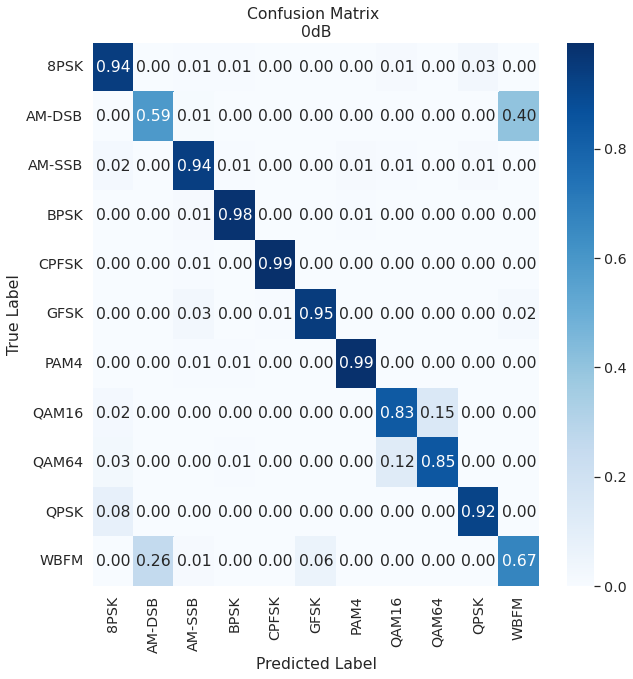

8


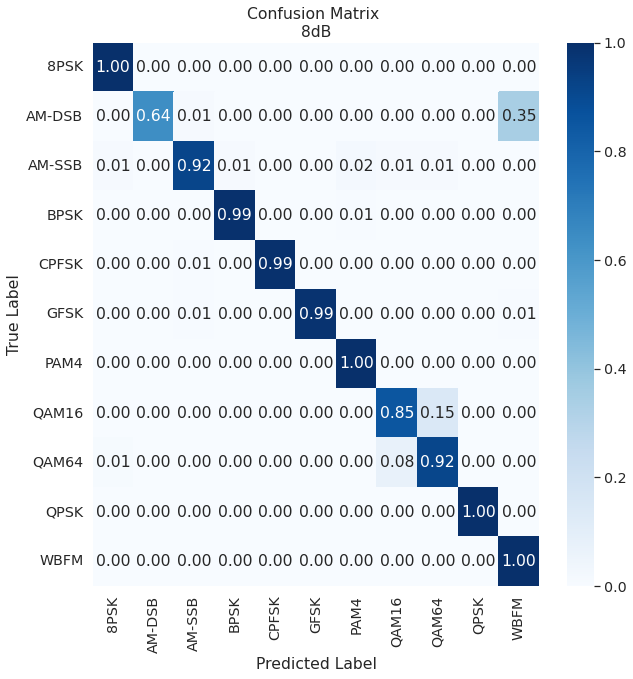

In [31]:
print(mods)
print(lbl_SNR.shape)
SNR_show_confusion_matrix([-6,0,8], lbl_SNR[:], X_test, save=False)